In [615]:
from typing import Callable, Dict, List, Tuple
import jax
import jax.numpy as jnp
from jax.tree_util import register_pytree_node_class
from functools import partial
import numpy as np
import time
import cv2
from pathlib import Path
import imgui
import moderngl
from pyrr import Matrix44
import moderngl_window as mglw
from moderngl_window import geometry
from moderngl_window.integrations.imgui import ModernglWindowRenderer
import PIL
from scipy.spatial import Delaunay
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

@register_pytree_node_class
class Gaussian:
    def __init__(self, eta, Lam):
        self.eta = eta
        self.Lam = Lam

    def tree_flatten(self):
        return (self.eta, self.Lam), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

    
    def mu(self):
        return jnp.where(
            jnp.allclose(self.Lam, 0), self.eta, jnp.linalg.solve(self.Lam, self.eta)
        )
    

    
    def sigma(self):
        return jnp.linalg.inv(self.Lam)

    def zero_like(self):
        return Gaussian(jnp.zeros_like(self.eta), jnp.zeros_like(self.Lam))

    def __repr__(self) -> str:
        return f"Gaussian(eta={self.eta}, lam={self.Lam})"

    def __mul__(self, other):
        return Gaussian(self.eta + other.eta, self.Lam + other.Lam)

    def __truediv__(self, other):
        return Gaussian(self.eta - other.eta, self.Lam - other.Lam)

    def copy(self):
        return Gaussian(self.eta.copy(), self.Lam.copy())


@register_pytree_node_class
class Variable:
    var_id: int
    belief: Gaussian
    msgs: Gaussian
    adj_factor_idx: jnp.array

    def __init__(self, var_id, belief, msgs, adj_factor_idx):
        self.var_id = var_id
        self.belief = belief
        self.msgs = msgs
        self.adj_factor_idx = adj_factor_idx

    def tree_flatten(self):
        return (self.var_id, self.belief, self.msgs, self.adj_factor_idx), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)


@register_pytree_node_class
class Factor:
    factor_id: jnp.array
    z: jnp.ndarray
    z_Lam: jnp.ndarray
    threshold: jnp.ndarray
    potential: Gaussian
    adj_var_id: jnp.array
    adj_var_idx: jnp.array

    def __init__(
        self, factor_id, z, z_Lam, threshold, potential, adj_var_id, adj_var_idx
    ):
        self.factor_id = factor_id
        self.z = z
        self.z_Lam = z_Lam
        self.threshold = threshold
        self.potential = potential
        self.adj_var_id = adj_var_id
        self.adj_var_idx = adj_var_idx

    def tree_flatten(self):
        return (
            self.factor_id,
            self.z,
            self.z_Lam,
            self.threshold,
            self.potential,
            self.adj_var_id,
            self.adj_var_idx,
        ), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)


@partial(jax.jit, static_argnames=["i", "j"])
def marginalize(gaussians: Gaussian, i, j): # Equ. (46), (47); Compute msg to i:j Variables from connected factors
    eta = gaussians.eta
    Lam = gaussians.Lam
    k = eta.size
    idx = jnp.arange(0, k)
    aa = idx[i:j] # index from i to j-1
    bb = jnp.concatenate([idx[:i], idx[j:]]) # rest
    aa_eta = eta[aa]
    bb_eta = eta[bb]
    aa_Lam = Lam[aa[:, None], aa]
    ab_Lam = Lam[aa[:, None], bb]
    bb_Lam = Lam[bb][:, bb]
    if bb_Lam.size == 0:
        return Gaussian(aa_eta, aa_Lam)
    # print("How large? ", bb_Lam.shape)

    bb_Cov = jnp.linalg.inv(bb_Lam)
    eta = aa_eta - ab_Lam @ bb_Cov @ bb_eta
    Lam = aa_Lam - ab_Lam @ bb_Cov @ ab_Lam.T
    return Gaussian(eta, Lam)




@partial(jax.jit, static_argnames=["axis"])
def tree_stack(tree, axis=0):
    return jax.tree_util.tree_map(lambda *v: jnp.stack(v, axis=axis), *tree)



@jax.jit
def h_fn(x):
    return x


@jax.jit
def h2_fn(xs):
    """
    xs: shape (2, D), where:
        - xs[0] is x1
        - xs[1] is x2
    """
    x1 = xs[0]
    x2 = xs[1]

    #jax.debug.print("Shape of x2 - x1: {}", (x2 - x1).shape)

    return x2 - x1


@jax.jit
def update_belief(var: Variable, ftov_msgs): # Calculate Eq. (7)
    belief = var.belief.zero_like()
    for i in range(ftov_msgs.eta.shape[0]):
        belief = belief * Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i])


    return belief


@jax.jit
def compute_vtof_msgs(var: Variable, ftov_msgs): # Eq.(19); do for each variable (x_m)
    vtof_msgs = []
    for i, idx in enumerate(var.adj_factor_idx): # for each f_si connected to x_m...
        msg = var.belief / Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i]) # Eq.(19) LHS subscript of SUM
        eta = jnp.where(idx < 0, msg.zero_like().eta, msg.eta) # Those not connected should not affect the calculation (idx < 0)
        Lam = jnp.where(idx < 0, msg.zero_like().Lam, msg.Lam) # The reason to not using "if" (while it's per-element) is to optimize better
        vtof_msgs.append(Gaussian(eta, Lam)) # append (x_m -> f_si)
    return tree_stack(vtof_msgs) # [(x_m -> f_s1), (x_m -> f_s2), ... ] # The length is Ni_v



@partial(jax.jit, static_argnames=["h_fn"])
def factor_energy(factor, xs, h_fn):
    h = h_fn(xs)
    z = factor.z
    z_Lam = factor.z_Lam
    r = z - h
    return 0.5 * r @ z_Lam @ r.T



@partial(jax.jit, static_argnames=["h_fn", "w"])
def factor_update(factor, xs, h_fn, w):
    h = h_fn(xs)
    J = jax.jacrev(h_fn)(xs).reshape(h.size, xs.size) # Jacobian auto-diff (J_s)


    z = factor.z # I think this is a vector
    z_Lam = factor.z_Lam
    
    r = z - h.reshape(-1) # TODO: reshape can be problematic
    s = w(r.T @ z_Lam @ r, factor.threshold) # Scale to consider Robust Loss
    Lam = s * J.T @ z_Lam @ J # Eq. (36)
    eta = s * J.T @ z_Lam @ (J @ xs.reshape(-1) + r) # TODO: reshape can be problematic; Eq. (36); xs should be a vector
    return Gaussian(eta, Lam) # Factor; represented w.r.t. neighboring variables xs



@jax.jit
def compute_ftov_msg(factor, vtof_msgs): # Ch 3.5 Message Passing at a Factor Node
    # vtof_msgs: Variable to Factor Messages; shape: (N_adj, dim) 
    # where N_adj is the number of adjacent variables and dim is the dimension of each variable

    N_adj, dim = vtof_msgs.eta.shape

    
    pot = factor.potential.copy() # log(f_s), but for only a specific variable a factor is connected to.
    i = 0
    for n in range(N_adj): # Add all! (Produce all)
        j = i + dim
        pot.eta = pot.eta.at[i:j].add(vtof_msgs.eta[n])
        pot.Lam = pot.Lam.at[i:j, i:j].add(vtof_msgs.Lam[n])
        i = j


    ftov_msgs = []
    i = 0
    for n in range(N_adj):
        j = i + dim
        pot_m_1 = pot.copy()
        pot_m_1.eta = pot_m_1.eta.at[i:j].add(-vtof_msgs.eta[n]) # Subtract direction of going out! (42)
        pot_m_1.Lam = pot_m_1.Lam.at[i:j, i:j].add(-vtof_msgs.Lam[n]) # (43)
        msg = marginalize(pot_m_1, i, j) # (46), (47)
        ftov_msgs.append(msg)
        i = j

    
    return tree_stack(ftov_msgs)


@jax.jit
def update_variable(varis): # Update belief with receiving msgs and calculate msg to factors; varis.msgs are up-to-date and varis.belief are not
    varis.belief = jax.vmap(update_belief)(varis, varis.msgs) # Eq. (7); varis.msgs is receiving msgs (ftov)
    vtof_msgs = jax.vmap(compute_vtof_msgs)(varis, varis.msgs) # Variable -> Factor Msg; Eq. (19)
    linpoints = jax.vmap(lambda x: x.mu())(varis.belief) # Current avg of belief! Belief is posterior

    return varis, vtof_msgs, linpoints # vtof msgs: # Var * # Var-direction (factor, Ni_v) msgs


@partial(jax.jit, static_argnames=["f", "w"])
def update_factor(facs, varis, vtof_msgs, linpoints, f, w): # f is factor function, w is robustifier
    vtof_msgs_reordered = jax.tree_util.tree_map( # Variable to factor messages to specific (variable, factor; or variable-direction) pair
        lambda x: x[facs.adj_var_id, facs.adj_var_idx], vtof_msgs # id: Variable id (one end), idx: direction (another end)
    )
    linpoints_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id], linpoints # Reorder linpoints by adj_var_id: variables' mean for factors' one ends
    )
    
    facs.potential = jax.vmap(factor_update, in_axes=(0, 0, None, None))( # Calculate each factor potential (f_s(x, x_1, ..., x_M) of Eq. (15))
        facs, linpoints_reordered, f, w # Each factor contribution of variable-direction pair (factor: variable-direction pair)
    ) # 1 or 2-dimensional!! (gradient / prior factor or smoothness factor)
    ftov_msgs = jax.vmap(compute_ftov_msg)(facs, vtof_msgs_reordered) # ftov calculation by Eq. (15), with potential f_s, and msg vtof

    varis.msgs.eta = varis.msgs.eta.at[facs.adj_var_id, facs.adj_var_idx].set( # Setting varis' receiving messages
        ftov_msgs.eta
    )
    varis.msgs.Lam = varis.msgs.Lam.at[facs.adj_var_id, facs.adj_var_idx].set(
        ftov_msgs.Lam
    )

    mask = (varis.adj_factor_idx >= 0)[..., None]
    varis.msgs.eta = varis.msgs.eta * mask
    varis.msgs.Lam = varis.msgs.Lam * mask[..., None]

    return facs, varis


@jax.jit
def huber(e, t):
    x = jnp.sqrt(e)
    return jnp.where(x <= t, 1.0, t / x)


@jax.jit
def l2(e, _):
    return 1.0

In [616]:
def build_pose_slam_graph(N, prior_meas, between_meas, prior_std=0.05, odom_std=0.05, Ni_v=10, D=2):
    """
    Build a 2D pose-SLAM factor graph with:
    - N variable nodes (each 2D position)
    - Prior measurements (with strong precision)
    - Between measurements (with moderate precision from noise_std)
    
    Parameters:
    - N: number of variables
    - prior_meas: list of (i, z) where z is the prior measurement at node i
    - between_meas: list of (i, j, z) where z is relative measurement from i to j
    - noise_std: standard deviation for between measurements (list or array of length D)
    - Ni_v: number of factor connections per variable (default 5)
    - D: dimension of each variable (default 2)
    
    Returns:
    - varis: Variable object
    - prior_facs: Factor object for priors
    - between_facs: Factor object for between factors
    """

    # === Step 1: Initialize Variable nodes ===
    var_ids = jnp.arange(N, dtype=jnp.int32)
    belief = Gaussian(jnp.zeros((N, D)), jnp.tile(jnp.eye(D), (N, 1, 1)))  # initial mean 0, covariance I
    msgs = Gaussian(jnp.zeros((N, Ni_v, D)), jnp.zeros((N, Ni_v, D, D)))  # messages (eta, Lambda) to each factor port
    adj_factor_idx = -jnp.ones((N, Ni_v), dtype=jnp.int32)  # -1 indicates no connected factor at this port

    varis = Variable(var_ids, belief, msgs, adj_factor_idx)

    # === Step 2: Build Prior Factors (strong precision for anchoring the graph) ===
    prior_factor_id = []
    prior_z = []
    prior_z_Lam = []
    prior_threshold = []
    prior_adj_var_id = []
    prior_adj_var_idx = []

    fac_counter = 0  # global factor ID counter

    for (i, z) in prior_meas:
        prior_factor_id.append(fac_counter)
        prior_z.append(jnp.array(z))

        # Very weak prior: large noise variance -> small precision
        prior_z_Lam.append(jnp.eye(D) / prior_std)  # shape (D, D)

        prior_threshold.append(1.0)
        prior_adj_var_id.append([i])     # only connected to variable i
        prior_adj_var_idx.append([0])     # use port 0 for prior

        varis.adj_factor_idx = varis.adj_factor_idx.at[i, 0].set(fac_counter)
        fac_counter += 1

    prior_facs = Factor(
        factor_id=jnp.array(prior_factor_id),
        z=jnp.stack(prior_z),
        z_Lam=jnp.stack(prior_z_Lam),
        threshold=jnp.array(prior_threshold),
        potential=None,
        adj_var_id=jnp.array(prior_adj_var_id),
        adj_var_idx=jnp.array(prior_adj_var_idx),
    )

    # === Step 3: Build Between Factors (relative pose measurements) ===
    between_factor_id = []
    between_z = []
    between_z_Lam = []
    between_threshold = []
    between_adj_var_id = []
    between_adj_var_idx = []

    for (i, j, z) in between_meas:
        between_factor_id.append(fac_counter)
        between_z.append(jnp.array(z))

        # Between-factor noise: use provided noise_std to compute precision
        between_z_Lam.append(jnp.diag(1.0 / (jnp.ones(D)*odom_std)   ))  # shape (D, D)

        between_threshold.append(1.0)

        # Assign first empty port >=1 to variable i and j
        port_i = int(jnp.argmax(varis.adj_factor_idx[i, 1:] == -1)) + 1
        port_j = int(jnp.argmax(varis.adj_factor_idx[j, 1:] == -1)) + 1
        varis.adj_factor_idx = varis.adj_factor_idx.at[i, port_i].set(fac_counter)
        varis.adj_factor_idx = varis.adj_factor_idx.at[j, port_j].set(fac_counter)

        between_adj_var_id.append([i, j])
        between_adj_var_idx.append([port_i, port_j])
        fac_counter += 1

    between_facs = Factor(
        factor_id=jnp.array(between_factor_id),
        z=jnp.stack(between_z),
        z_Lam=jnp.stack(between_z_Lam),
        threshold=jnp.array(between_threshold),
        potential=None,
        adj_var_id=jnp.array(between_adj_var_id),
        adj_var_idx=jnp.array(between_adj_var_idx),
    )

    return varis, prior_facs, between_facs


In [617]:
def generate_grid_slam_data(H=16, W=16, dx=1.0, dy=1.0, prior_noise_std=0.05, odom_noise_std=0.05, seed=0):
    """
    Generate 2D SLAM data over a regular H x W grid.

    Each variable is a node located at position (j*dx, i*dy), where i is row index and j is column index.
    Relative pose measurements (between factors) are added between horizontal and vertical neighbors.
    Each variable also receives a weak but accurate prior to ensure the global graph is well-constrained.

    Args:
        H: number of rows in the grid
        W: number of columns in the grid
        dx: horizontal spacing between grid points
        dy: vertical spacing between grid points
        odom_noise_std: standard deviation of noise added to relative measurements (between factors)
        prior_std: standard deviation for prior factors (should be much larger than odom_noise_std to make priors weak)
        seed: random seed for reproducibility

    Returns:
        positions: (N, 2) array of ground-truth positions (N = H * W)
        prior_meas: list of (i, z) where i is variable index and z is its true position
        between_meas: list of (i, j, z) where (i, j) is a measurement edge and z is the noisy relative pose from i to j
    """
    np.random.seed(seed)
    N = H * W  # total number of variables

    # Step 1: Generate ground-truth positions on the grid
    positions = []
    for i in range(H):
        for j in range(W):
            x = j * dx
            y = -i * dy
            positions.append([x, y])
    positions = np.array(positions)  # shape (N, 2)

    # Step 2: Add weak but accurate prior for each variable
    prior_meas = []
    for idx, pos in enumerate(positions):
        noise = np.random.randn(2) * prior_noise_std
        z = (pos + noise).tolist()
        prior_meas.append((idx, z))  # accurate measurement with weak information will be set in z_Lam later

    # Step 3: Add noisy relative pose measurements (between factors)
    between_meas = []
    for i in range(H):
        for j in range(W):
            idx = i * W + j  # flat index of (i, j)

            # Horizontal neighbor (i, j) -> (i, j+1)
            if j < W - 1:
                nbr = i * W + (j + 1)
                rel = positions[nbr] - positions[idx]  # ideal relative translation
                noise = np.random.randn(2) * odom_noise_std
                z = (rel + noise).tolist()
                between_meas.append((idx, nbr, z))

            # Vertical neighbor (i, j) -> (i+1, j)
            if i < H - 1:
                nbr = (i + 1) * W + j
                rel = positions[nbr] - positions[idx]
                noise = np.random.randn(2) * odom_noise_std
                #z = (rel + noise).tolist()
                z = noise.tolist()
                between_meas.append((idx, nbr, z))

    return positions, prior_meas, between_meas


In [618]:
def gbp_solve(varis, prior_facs, between_facs, num_iters=50, visualize=False, prior_h=h_fn, between_h=h2_fn):
    energy_log = []
    

    if visualize:
        varis, vtof_msgs, linpoints = update_variable(varis)
        # Energy computation
        prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            prior_facs, linpoints[prior_facs.adj_var_id[:, 0]], prior_h
        ))

        between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            between_facs, linpoints[between_facs.adj_var_id], between_h
        ))

        energy = prior_energy + between_energy
        energy_log.append(energy)


    for i in range(num_iters):
        # Step 1: Variable update
        varis, vtof_msgs, linpoints = update_variable(varis)

        # Step 2: Factor update
        prior_facs, varis = update_factor(prior_facs, varis, vtof_msgs, linpoints, prior_h, l2)
        between_facs, varis = update_factor(between_facs, varis, vtof_msgs, linpoints, between_h, l2)


        if visualize:
            # Step 3: Energy computation
            prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                prior_facs, linpoints[prior_facs.adj_var_id[:, 0]], prior_h
            ))
    
            between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                between_facs, linpoints[between_facs.adj_var_id], between_h
            ))
    
            energy = prior_energy + between_energy
            energy_log.append(energy)
        

    # Step 4: Keep linpoints
    linpoints = jax.vmap(lambda x: x.mu())(varis.belief)  
        
    return varis, prior_facs, between_facs, np.array(energy_log), linpoints


In [619]:
positions, prior_meas, between_meas = generate_grid_slam_data(H=16, W=16, 
                                    prior_noise_std=1, odom_noise_std=0.01, seed=0)
varis, prior_facs, between_facs = build_pose_slam_graph(N=256, prior_meas=prior_meas, between_meas=between_meas, 
                                                        prior_std=1, odom_std=0.01,
                                                        Ni_v=10, D=2)

cpu_device = jax.devices("cpu")[0]
varis= jax.device_put(varis, cpu_device)
prior_facs = jax.device_put(prior_facs, cpu_device)
between_facs = jax.device_put(between_facs, cpu_device)

"""
print("var_id:", varis.var_id.shape)            # should be (N,)
print("belief.eta:", varis.belief.eta.shape)    # should be (N, D)
print("belief.Lam:", varis.belief.Lam.shape)    # should be (N, D, D)
print("msgs.eta:", varis.msgs.eta.shape)        # should be (N, Ni_v, D)
print("msgs.Lam:", varis.msgs.Lam.shape)        # should be (N, Ni_v, D, D)
print("adj_factor_idx:", varis.adj_factor_idx.shape)  # should be (N, Ni_v)
"""

varis, prior_facs, between_facs, energy_log, linpoints = gbp_solve(
    varis, prior_facs, between_facs, num_iters=30, visualize=True
)


varis.belief.mu()
energy_log

array([ 32055.207 ,  32055.207 , 109868.08  ,  22361.291 ,  15052.158 ,
        12064.397 ,  10659.524 ,   9783.627 ,   9156.4   ,   8671.019 ,
         8254.848 ,   7894.5464,   7561.6685,   7259.681 ,   6975.417 ,
         6714.346 ,   6466.488 ,   6237.607 ,   6019.651 ,   5817.9185,
         5625.5547,   5447.2607,   5277.1245,   5119.3066,   4968.646 ,
         4828.823 ,   4695.3125,   4571.361 ,   4452.9883,   4343.0635,
         4238.074 ], dtype=float32)

In [ ]:
@jax.jit
def h3_fn(x):
    """
    Predicts measurement h(x) for coarse prior.

    Input:
        x: (8,) → 4 stacked fine-level variables (each 2D)
    Output:
        z_hat: (16,) = [x0, x1, x2, x3, x1-x0, x2-x0, x3-x1, x3-x2]
    """
    x = x.reshape(-1)
    
    x0 = x[0:2]
    x1 = x[2:4]
    x2 = x[4:6]
    x3 = x[6:8]

    # 4 priors (just xi)
    z_hat_0 = x0
    z_hat_1 = x1
    z_hat_2 = x2
    z_hat_3 = x3

    # 4 internal between
    z_hat_4 = x1 - x0
    z_hat_5 = x2 - x0
    z_hat_6 = x3 - x1
    z_hat_7 = x3 - x2

    return jnp.concatenate([
        z_hat_0, z_hat_1, z_hat_2, z_hat_3,
        z_hat_4, z_hat_5, z_hat_6, z_hat_7
    ])


@jax.jit
def h4_fn(xs):
    """
    Predicts coarse between measurement h(xs) where:
      - xs[0] is coarse variable i (8D)
      - xs[1] is coarse variable j (8D)
    Fixed: uses v01→v02 and v11→v12 edges
    
    Returns:
        z_hat: shape (4,) = two 2D relative positions
    """
    xi = xs[0]
    xj = xs[1]

    # First residual: xj[0:2] - xi[2:4]  (v02 - v01)
    r1 = xj[0:2] - xi[2:4]

    # Second residual: xj[4:6] - xi[6:8] (v12 - v11)
    r2 = xj[4:6] - xi[6:8]

    return jnp.concatenate([r1, r2])  # shape (4,)


@jax.jit
def h5_fn(xs):
    """
    Predicts coarse between measurement h(xs) where:
      - xs[0] is coarse variable i (8D)
      - xs[1] is coarse variable j (8D)
    Fixed: uses v10→v20 and v11→v21 edges

    Returns:
        z_hat: shape (4,) = two 2D relative positions
    """
    xi = xs[0]
    xj = xs[1]

    # First residual: xj[0:2] - xi[4:6]  (v20 - v10)
    r1 = xj[0:2] - xi[4:6]

    # Second residual: xj[2:4] - xi[6:8] (v21 - v11)
    r2 = xj[2:4] - xi[6:8]

    return jnp.concatenate([r1, r2])  # shape (4,)


In [ ]:
def build_coarse_slam_graph(
    varis_fine: Variable,
    prior_facs_fine: Factor,
    between_facs_fine: Factor,
    H: int, W: int,
    stride: int = 2,
    prior_std: float = 1.0,
    between_std: float = 0.1,
) -> Tuple[Variable, Factor, Factor]:
    D = 2
    patch_map: Dict[int, List[int]] = {}
    fine_to_patch: Dict[int, Tuple[int, int]] = {}
    coarse_var_id = 0

    coarse_beliefs = []
    coarse_msgs_eta = []
    coarse_msgs_Lam = []
    coarse_adj_factor_idx = []


    # === 1. Build Coarse Variables ===
    for i in range(0, H - 1, stride):
        for j in range(0, W - 1, stride):
            v00 = i * W + j
            v01 = v00 + 1
            v10 = v00 + W
            v11 = v10 + 1
            patch = [v00, v01, v10, v11]
            patch_map[coarse_var_id] = patch
            for k, vid in enumerate(patch):
                fine_to_patch[vid] = (coarse_var_id, k)

            Ni_v = 15
            eta = jnp.zeros((8))  # 8D for coarse variable
            Lam = jnp.zeros((8, 8))
            coarse_beliefs.append(Gaussian(eta, Lam))


            coarse_msgs_eta.append(jnp.zeros((Ni_v, 8)))
            coarse_msgs_Lam.append(jnp.zeros((Ni_v, 8, 8)))
            coarse_adj_factor_idx.append(-jnp.ones(Ni_v, dtype=jnp.int32))
            coarse_var_id += 1

    varis_coarse = Variable(
        var_id=jnp.arange(len(patch_map)),
        belief=tree_stack(coarse_beliefs, axis=0),
        msgs=Gaussian(jnp.stack(coarse_msgs_eta), jnp.stack(coarse_msgs_Lam)),
        adj_factor_idx=jnp.stack(coarse_adj_factor_idx),
    )

    # === 2. Build Coarse Priors ===
    fine_between_dict = {
        (int(i), int(j)): k for k, (i, j) in enumerate(between_facs_fine.adj_var_id)
    }

    fine_between_dict.update({(int(j), int(i)): k for k, (i, j) in enumerate(between_facs_fine.adj_var_id)})

    prior_ids, prior_zs, prior_zLams = [], [], []
    adj_var_ids, adj_var_idxs = [], []
    factor_id_counter = 0

    for patch_id, patch in patch_map.items():
        residuals = []
        precisions = []

        for v in patch:
            mask = (prior_facs_fine.adj_var_id[:, 0] == v)
            if jnp.any(mask):
                i = jnp.argmax(mask)
                z_i = prior_facs_fine.z[i]
                z_Lam_i = prior_facs_fine.z_Lam[i]
            else:
                z_i = jnp.zeros((D,))
                z_Lam_i = (1. / (prior_std ** 2)) * jnp.eye(D)
            residuals.append(z_i)
            precisions.append(z_Lam_i)

        edge_indices = [(0, 1), (0, 2), (1, 3), (2, 3)]
        for i, j in edge_indices:
            a, b = patch[i], patch[j]
            key = (a, b)
            if key in fine_between_dict:
                k = fine_between_dict[key]
                a_k, b_k = between_facs_fine.adj_var_id[k]
                z = between_facs_fine.z[k]
                z_Lam = between_facs_fine.z_Lam[k]
                if a_k == b:
                    z = -z
                
                residuals.append(z)
                precisions.append(z_Lam)
            else:
                residuals.append(jnp.zeros((D,)))
                precisions.append((1. / (between_std ** 2)) * jnp.eye(D))

        z = jnp.concatenate(residuals)
        z_Lam = jax.scipy.linalg.block_diag(*precisions)


        prior_ids.append(factor_id_counter)
        prior_zs.append(z)
        prior_zLams.append(z_Lam)
        adj_var_ids.append(jnp.array([patch_id]))
        adj_var_idxs.append(jnp.array([0]))

        varis_coarse.adj_factor_idx = varis_coarse.adj_factor_idx.at[patch_id, 0].set(factor_id_counter)
        factor_id_counter += 1


    prior_facs_coarse = Factor(
        factor_id=jnp.array(prior_ids, dtype=jnp.int32),
        z=jnp.stack(prior_zs),
        z_Lam=jnp.stack(prior_zLams),
        threshold=jnp.ones((len(prior_ids),)),
        potential=None,
        adj_var_id=jnp.stack(adj_var_ids),
        adj_var_idx=jnp.stack(adj_var_idxs),
    )

    # === Build Horizontal & Vertical Between Factors Separately ===
    horizontal_ids, horizontal_zs, horizontal_zLams = [], [], []
    horizontal_adj_ids, horizontal_adj_idxs = [], []

    vertical_ids, vertical_zs, vertical_zLams = [], [], []
    vertical_adj_ids, vertical_adj_idxs = [], []

    height = H // stride
    width = W // stride

    for row in range(height):
        for col in range(width):
            patch_i = row * width + col

            # Horizontal neighbor
            if col < width - 1:
                patch_j = patch_i + 1
                pi_patch, pj_patch = patch_map[patch_i], patch_map[patch_j]

                fine_pairs = [(pi_patch[1], pj_patch[0]), (pi_patch[3], pj_patch[2])]

                residuals = []
                precisions = []
                for a, b in fine_pairs:
                    key = (a, b)
                    if key in fine_between_dict:
                        k = fine_between_dict[key]
                        a_k, b_k = between_facs_fine.adj_var_id[k]
                        z = between_facs_fine.z[k]
                        z_Lam = between_facs_fine.z_Lam[k]
                        if a_k == b:
                            z = -z
                    else:
                        z = jnp.zeros((D,))
                        z_Lam = (1. / (between_std ** 2)) * jnp.eye(D)
                    residuals.append(z)
                    precisions.append(z_Lam)

                z = jnp.concatenate(residuals)
                z_Lam = jax.scipy.linalg.block_diag(*precisions)

                adj_id = jnp.array([patch_i, patch_j])
                port_i = int(jnp.argmax(varis_coarse.adj_factor_idx[patch_i] == -1))
                port_j = int(jnp.argmax(varis_coarse.adj_factor_idx[patch_j] == -1))
                adj_idx = jnp.array([port_i, port_j])

                horizontal_ids.append(factor_id_counter)
                horizontal_zs.append(z)
                horizontal_zLams.append(z_Lam)
                horizontal_adj_ids.append(adj_id)
                horizontal_adj_idxs.append(adj_idx)

                
                varis_coarse.adj_factor_idx = varis_coarse.adj_factor_idx.at[patch_i, port_i].set(factor_id_counter)
                varis_coarse.adj_factor_idx = varis_coarse.adj_factor_idx.at[patch_j, port_j].set(factor_id_counter)

                factor_id_counter += 1

            # Vertical neighbor
            if row < height - 1:
                patch_j = patch_i + width
                pi_patch, pj_patch = patch_map[patch_i], patch_map[patch_j]
                fine_pairs = [(pi_patch[2], pj_patch[0]), (pi_patch[3], pj_patch[1])]

                residuals = []
                precisions = []
                for a, b in fine_pairs:
                    key = (a, b)
                    if key in fine_between_dict:
                        k = fine_between_dict[key]
                        a_k, b_k = between_facs_fine.adj_var_id[k]
                        z = between_facs_fine.z[k]
                        z_Lam = between_facs_fine.z_Lam[k]
                        if a_k == b:
                            z = -z
                    else:
                        z = jnp.zeros((D,))
                        z_Lam = (1. / (between_std ** 2)) * jnp.eye(D)
                    residuals.append(z)
                    precisions.append(z_Lam)

                z = jnp.concatenate(residuals)
                z_Lam = jax.scipy.linalg.block_diag(*precisions)

                adj_id = jnp.array([patch_i, patch_j])
                port_i = int(jnp.argmax(varis_coarse.adj_factor_idx[patch_i] == -1))
                port_j = int(jnp.argmax(varis_coarse.adj_factor_idx[patch_j] == -1))
                adj_idx = jnp.array([port_i, port_j])

                vertical_ids.append(factor_id_counter)
                vertical_zs.append(z)
                vertical_zLams.append(z_Lam)
                vertical_adj_ids.append(adj_id)
                vertical_adj_idxs.append(adj_idx)

                varis_coarse.adj_factor_idx = varis_coarse.adj_factor_idx.at[patch_i, port_i].set(factor_id_counter)
                varis_coarse.adj_factor_idx = varis_coarse.adj_factor_idx.at[patch_j, port_j].set(factor_id_counter)


                factor_id_counter += 1

    horizontal_between_facs = Factor(
        factor_id=jnp.array(horizontal_ids, dtype=jnp.int32),
        z=jnp.stack(horizontal_zs),
        z_Lam=jnp.stack(horizontal_zLams),
        threshold=jnp.ones((len(horizontal_ids),)),
        potential=None,
        adj_var_id=jnp.stack(horizontal_adj_ids),
        adj_var_idx=jnp.stack(horizontal_adj_idxs),
    )

    vertical_between_facs = Factor(
        factor_id=jnp.array(vertical_ids, dtype=jnp.int32),
        z=jnp.stack(vertical_zs),
        z_Lam=jnp.stack(vertical_zLams),
        threshold=jnp.ones((len(vertical_ids),)),
        potential=None,
        adj_var_id=jnp.stack(vertical_adj_ids),
        adj_var_idx=jnp.stack(vertical_adj_idxs),
    )

    return varis_coarse, prior_facs_coarse, horizontal_between_facs, vertical_between_facs

In [ ]:
# === Step 2: construct coarse-level graph ===
varis_coarse, prior_facs_coarse, horizontal_between_facs, vertical_between_facs  = build_coarse_slam_graph(
    varis_fine=varis,
    prior_facs_fine=prior_facs,
    between_facs_fine=between_facs,
    H=16, W=16,
    stride = 2,
    prior_std = 1.0,
    between_std = 0.1,
)

# === Step 3: print coarse-level factor numbers to verify===
print("Coarse Variables:", len(varis_coarse.var_id))
print("Coarse Prior Factors:", len(prior_facs_coarse.factor_id))
print("Coarse Horizontal Between Factors:", len(horizontal_between_facs.factor_id))
print("Coarse vertical Between Factors:", len(vertical_between_facs.factor_id))

k = 0  # factor index，e.g. 0~63

print("=== Prior Factor #{} ===".format(k))
print("factor_id:", prior_facs_coarse.factor_id[k])
print("adj_var_id:", prior_facs_coarse.adj_var_id[k])     # coarse variable index
print("adj_var_idx:", prior_facs_coarse.adj_var_idx[k])   # always [0] since 1 variable
print("z (residual target):\n", prior_facs_coarse.z[k])   # shape: (16,)
print("z_Lam (precision matrix):\n", prior_facs_coarse.z_Lam[k])  # shape: (16, 16)
print("threshold:", prior_facs_coarse.threshold[k])

k = 0

print(f"\n=== Coarse Between Factor #{k} ===")
print("factor_id:", horizontal_between_facs.factor_id[k])

print("adj_var_id:", horizontal_between_facs.adj_var_id[k])     # coarse variable IDs
print("adj_var_idx:", horizontal_between_facs.adj_var_idx[k])   # slot idxs on both vars

print("z (residual):", horizontal_between_facs.z[k])            # shape: (4,)
print("z_Lam (precision):\n", horizontal_between_facs.z_Lam[k])  # shape: (4,4)

print("threshold:", horizontal_between_facs.threshold[k])


Coarse Variables: 64
Coarse Prior Factors: 64
Coarse Horizontal Between Factors: 56
Coarse vertical Between Factors: 56
=== Prior Factor #0 ===
factor_id: 0
adj_var_id: [0]
adj_var_idx: [0]
z (residual target):
 [ 1.7640524e+00  4.0015721e-01  1.9787380e+00  2.2408931e+00
 -8.8778573e-01 -2.9807966e+00  6.5208787e-01 -8.4365106e-01
  9.8667789e-01 -1.9686246e-02 -6.6005634e-03  1.7581895e-03
  2.8427967e-03  1.7426688e-02  1.0058988e+00 -3.6385881e-03]
z_Lam (precision matrix):
 [[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.

In [ ]:
def gbp_solve_coarse(varis, prior_facs, horizontal_between_facs, vertical_between_facs, num_iters=50, 
                    visualize=False, prior_h=h3_fn, between_h=[h4_fn,h5_fn]):
    energy_log = []
    
    """
    if visualize:
        varis, vtof_msgs, linpoints = update_variable(varis)
        # Energy computation
        prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            prior_facs, linpoints[prior_facs.adj_var_id[:, 0]], prior_h
        ))

        horizontal_between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            horizontal_between_facs, linpoints[horizontal_between_facs.adj_var_id], between_h[0]
        ))

        vertical_between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            vertical_between_facs, linpoints[vertical_between_facs.adj_var_id], between_h[1]
        ))

        energy = prior_energy + horizontal_between_energy + vertical_between_energy
        energy_log.append(energy)
    """ 
    
    # Initialize variable with priors 
    varis, vtof_msgs, linpoints = update_variable(varis)
    prior_facs, varis = update_factor(prior_facs, varis, vtof_msgs, linpoints, prior_h, l2)
    if visualize:
        # Energy computation
        prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            prior_facs, linpoints[prior_facs.adj_var_id[:, 0]], prior_h
        ))

        horizontal_between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            horizontal_between_facs, linpoints[horizontal_between_facs.adj_var_id], between_h[0]
        ))


        vertical_between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            vertical_between_facs, linpoints[vertical_between_facs.adj_var_id], between_h[1]
        ))


        energy = prior_energy + horizontal_between_energy + vertical_between_energy
        energy_log.append(energy)


    for i in range(num_iters-1):
        # Step 1: Variable update
        varis, vtof_msgs, linpoints = update_variable(varis)

        # Step 2: Factor update
        prior_facs, varis = update_factor(prior_facs, varis, vtof_msgs, linpoints, prior_h, l2)


        horizontal_between_facs, varis = update_factor(horizontal_between_facs, varis, vtof_msgs, 
                                                       linpoints, between_h[0], l2)

        vertical_between_facs, varis = update_factor(vertical_between_facs, varis, vtof_msgs, 
                                                       linpoints, between_h[1], l2)
        
        if visualize:
            # Step 3: Energy computation
            prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                prior_facs, linpoints[prior_facs.adj_var_id[:, 0]], prior_h
            ))
    
            horizontal_between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                horizontal_between_facs, linpoints[horizontal_between_facs.adj_var_id], between_h[0]
            ))
    
            vertical_between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                vertical_between_facs, linpoints[vertical_between_facs.adj_var_id], between_h[1]
            ))

            energy = prior_energy + horizontal_between_energy + vertical_between_energy

            energy_log.append(energy)
        

    # Step 4: Keep linpoints
    linpoints = jax.vmap(lambda x: x.mu())(varis.belief)  
        
    return varis, prior_facs, horizontal_between_facs, vertical_between_facs, np.array(energy_log), linpoints

In [603]:
cpu_device = jax.devices("cpu")[0]
varis_coarse= jax.device_put(varis_coarse, cpu_device)
prior_facs_coarse = jax.device_put(prior_facs_coarse, cpu_device)
horizontal_between_facs = jax.device_put(horizontal_between_facs, cpu_device)
vertical_between_facs = jax.device_put(vertical_between_facs, cpu_device)


print("var_id:", varis_coarse.var_id.shape)            # should be (N,)
print("belief.eta:", varis_coarse.belief.eta.shape)    # should be (N, D)
print("belief.Lam:", varis_coarse.belief.Lam.shape)    # should be (N, D, D)
print("msgs.eta:", varis_coarse.msgs.eta.shape)        # should be (N, Ni_v, D)
print("msgs.Lam:", varis_coarse.msgs.Lam.shape)        # should be (N, Ni_v, D, D)
print("adj_factor_idx:", varis_coarse.adj_factor_idx.shape)  # should be (N, Ni_v)



varis_coarse, prior_facs_coarse, horizontal_between_facs, vertical_between_facs, energy_log_coarse, linpoints = gbp_solve_coarse(
    varis_coarse, prior_facs_coarse, horizontal_between_facs, vertical_between_facs, 
    num_iters=30, visualize=True
)


"""
varis_coarse, vtof_msgs, linpoints = update_variable(varis_coarse)


# Step 2: Factor update
prior_facs_coarse, varis_coarse = update_factor(prior_facs_coarse, varis_coarse, vtof_msgs, linpoints, h3_fn, l2)
varis_coarse, vtof_msgs, linpoints = update_variable(varis_coarse)

horizontal_between_facs, varis_coarse = update_factor(horizontal_between_facs, varis_coarse, vtof_msgs, linpoints, h4_fn, l2)
vertical_between_facs, varis_coarse = update_factor(vertical_between_facs, varis_coarse, vtof_msgs, linpoints, h5_fn, l2)


varis_coarse, vtof_msgs, linpoints = update_variable(varis_coarse)


# Step 2: Factor update
prior_facs_coarse, varis_coarse = update_factor(prior_facs_coarse, varis_coarse, vtof_msgs, linpoints, h3_fn, l2)
"""

var_id: (64,)
belief.eta: (64, 8)
belief.Lam: (64, 8, 8)
msgs.eta: (64, 15, 8)
msgs.Lam: (64, 15, 8, 8)
adj_factor_idx: (64, 15)


'\nvaris_coarse, vtof_msgs, linpoints = update_variable(varis_coarse)\n\n\n# Step 2: Factor update\nprior_facs_coarse, varis_coarse = update_factor(prior_facs_coarse, varis_coarse, vtof_msgs, linpoints, h3_fn, l2)\nvaris_coarse, vtof_msgs, linpoints = update_variable(varis_coarse)\n\nhorizontal_between_facs, varis_coarse = update_factor(horizontal_between_facs, varis_coarse, vtof_msgs, linpoints, h4_fn, l2)\nvertical_between_facs, varis_coarse = update_factor(vertical_between_facs, varis_coarse, vtof_msgs, linpoints, h5_fn, l2)\n\n\nvaris_coarse, vtof_msgs, linpoints = update_variable(varis_coarse)\n\n\n# Step 2: Factor update\nprior_facs_coarse, varis_coarse = update_factor(prior_facs_coarse, varis_coarse, vtof_msgs, linpoints, h3_fn, l2)\n'

In [ ]:
def build_coarser_slam_graph(
    varis_coarse: Variable,
    prior_facs_coarse: Factor,
    horizontal_between_facs: Factor,
    vertical_between_facs: Factor,
    H: int, W: int,
    stride: int = 2,
):
    
    patch_map: Dict[int, List[int]] = {}
    coarse_to_patch: Dict[int, Tuple[int, int]] = {}
    coarser_var_id = 0


    coarser_beliefs = []
    coarser_msgs_eta = []
    coarser_msgs_Lam = []
    coarser_adj_factor_idx = []

    H = H//2
    W = W//2

    # === 1. Build Coarse Variables ===
    for i in range(0, H - 1, stride):
        for j in range(0, W - 1, stride):
            v00 = i * W + j
            v01 = v00 + 1
            v10 = v00 + W
            v11 = v10 + 1
            patch = [v00, v01, v10, v11]
            patch_map[coarser_var_id] = patch
            for k, vid in enumerate(patch):
                coarse_to_patch[vid] = (coarser_var_id, k)

            Ni_v = 20
            eta = jnp.zeros((32))  # 32D for coarse variable
            Lam = jnp.zeros((32, 32))
            coarser_beliefs.append(Gaussian(eta, Lam))

            coarser_msgs_eta.append(jnp.zeros((Ni_v, 32)))
            coarser_msgs_Lam.append(jnp.zeros((Ni_v, 32, 32)))
            coarser_adj_factor_idx.append(-jnp.ones(Ni_v, dtype=jnp.int32))
            coarser_var_id += 1


    varis_coarser = Variable(
        var_id=jnp.arange(len(patch_map)),
        belief=tree_stack(coarser_beliefs, axis=0),
        msgs=Gaussian(jnp.stack(coarser_msgs_eta), jnp.stack(coarser_msgs_Lam)),
        adj_factor_idx=jnp.stack(coarser_adj_factor_idx),
    )


    # === 2. Build Coarser Priors ===
    horizontal_between_facs_dict = {
        (int(i), int(j)): k for k, (i, j) in enumerate(horizontal_between_facs.adj_var_id)
    }
    horizontal_between_facs_dict.update(
        {(int(j), int(i)): k for k, (i, j) in enumerate(horizontal_between_facs.adj_var_id)})

    vertical_between_facs_dict = {
        (int(i), int(j)): k for k, (i, j) in enumerate(vertical_between_facs.adj_var_id)
    }
    vertical_between_facs_dict.update(
        {(int(j), int(i)): k for k, (i, j) in enumerate(vertical_between_facs.adj_var_id)})
    
    #print("horizontal_between_facs_dict",horizontal_between_facs_dict)

    prior_ids, prior_zs, prior_zLams = [], [], []
    adj_var_ids, adj_var_idxs = [], []
    factor_id_counter = 0

    for patch_id, patch in patch_map.items():
        residuals = []
        precisions = []

        for v in patch:
            mask = (prior_facs_coarse.adj_var_id[:, 0] == v)

            i = jnp.argmax(mask)
            z_i = prior_facs_coarse.z[i]
            z_Lam_i = prior_facs_coarse.z_Lam[i]

            residuals.append(z_i)
            precisions.append(z_Lam_i)

        edge_indices = [(0, 1), (0, 2), (1, 3), (2, 3)]
        for i, j in edge_indices:
            a, b = patch[i], patch[j]

            #print("ijab:",i,j,a,b)
            key = (a, b)

            if key in horizontal_between_facs_dict:
                k = horizontal_between_facs_dict[key]
                z = horizontal_between_facs.z[k]
                z_Lam = horizontal_between_facs.z_Lam[k]
                
            elif key in vertical_between_facs_dict:
                k = vertical_between_facs_dict[key]
                z = vertical_between_facs.z[k]
                z_Lam = vertical_between_facs.z_Lam[k]
                
            residuals.append(z)
            precisions.append(z_Lam)


        z = jnp.concatenate(residuals)
        z_Lam = jax.scipy.linalg.block_diag(*precisions)


        prior_ids.append(factor_id_counter)
        prior_zs.append(z)
        prior_zLams.append(z_Lam)
        adj_var_ids.append(jnp.array([patch_id]))
        adj_var_idxs.append(jnp.array([0]))

        varis_coarser.adj_factor_idx = varis_coarser.adj_factor_idx.at[patch_id, 0].set(factor_id_counter)
        factor_id_counter += 1


    prior_facs_coarser = Factor(
        factor_id=jnp.array(prior_ids, dtype=jnp.int32),
        z=jnp.stack(prior_zs),
        z_Lam=jnp.stack(prior_zLams),
        threshold=jnp.ones((len(prior_ids),)),
        potential=None,
        adj_var_id=jnp.stack(adj_var_ids),
        adj_var_idx=jnp.stack(adj_var_idxs),
    )


    # === Build Horizontal & Vertical Between Factors Separately ===
    horizontal_ids, horizontal_zs, horizontal_zLams = [], [], []
    horizontal_adj_ids, horizontal_adj_idxs = [], []

    vertical_ids, vertical_zs, vertical_zLams = [], [], []
    vertical_adj_ids, vertical_adj_idxs = [], []

    height = H // stride
    width = W // stride

    for row in range(height):
        for col in range(width):
            patch_i = row * width + col

            # Horizontal neighbor
            if col < width - 1:
                patch_j = patch_i + 1
                pi_patch, pj_patch = patch_map[patch_i], patch_map[patch_j]

                # pi_patch 0,1,8,9, pj_patch 2,3,10,11 
                coarse_pairs = [(pi_patch[1], pj_patch[0]), (pi_patch[3], pj_patch[2])]

                residuals = []
                precisions = []
                for a, b in coarse_pairs:
                    key = (a, b)
                    k = horizontal_between_facs_dict[key]

                    z = horizontal_between_facs.z[k]
                    z_Lam = horizontal_between_facs.z_Lam[k]


                    residuals.append(z)
                    precisions.append(z_Lam)


                z = jnp.concatenate(residuals)
                z_Lam = jax.scipy.linalg.block_diag(*precisions)

                adj_id = jnp.array([patch_i, patch_j])
                port_i = int(jnp.argmax(varis_coarser.adj_factor_idx[patch_i] == -1))
                port_j = int(jnp.argmax(varis_coarser.adj_factor_idx[patch_j] == -1))
                adj_idx = jnp.array([port_i, port_j])


                horizontal_ids.append(factor_id_counter)
                horizontal_zs.append(z)
                horizontal_zLams.append(z_Lam)
                horizontal_adj_ids.append(adj_id)
                horizontal_adj_idxs.append(adj_idx)

                varis_coarser.adj_factor_idx = varis_coarser.adj_factor_idx.at[patch_i, port_i].set(factor_id_counter)
                varis_coarser.adj_factor_idx = varis_coarser.adj_factor_idx.at[patch_j, port_j].set(factor_id_counter)

                factor_id_counter += 1


            # Vertical neighbor
            if row < height - 1:
                patch_j = patch_i + width
                pi_patch, pj_patch = patch_map[patch_i], patch_map[patch_j]
                coarse_pairs = [(pi_patch[2], pj_patch[0]), (pi_patch[3], pj_patch[1])]

                residuals = []
                precisions = []
                for a, b in coarse_pairs:
                    key = (a, b)
                    k = vertical_between_facs_dict[key]

                    a_k = vertical_between_facs.adj_var_id[k, 0]  # coarse variable id
                    #print("vertical, k, key=(a,b)",k,key)
                    z = vertical_between_facs.z[k]
                    z_Lam = vertical_between_facs.z_Lam[k]
                    if a_k == b:
                            z = -z


                    residuals.append(z)
                    precisions.append(z_Lam)

                z = jnp.concatenate(residuals)
                z_Lam = jax.scipy.linalg.block_diag(*precisions)

                adj_id = jnp.array([patch_i, patch_j])
                port_i = int(jnp.argmax(varis_coarser.adj_factor_idx[patch_i] == -1))
                port_j = int(jnp.argmax(varis_coarser.adj_factor_idx[patch_j] == -1))
                adj_idx = jnp.array([port_i, port_j])

            
                #print("vertical", factor_id_counter)
                vertical_ids.append(factor_id_counter)
                vertical_zs.append(z)
                vertical_zLams.append(z_Lam)
                vertical_adj_ids.append(adj_id)
                vertical_adj_idxs.append(adj_idx)

                varis_coarser.adj_factor_idx = varis_coarser.adj_factor_idx.at[patch_i, port_i].set(factor_id_counter)
                varis_coarser.adj_factor_idx = varis_coarser.adj_factor_idx.at[patch_j, port_j].set(factor_id_counter)

                factor_id_counter += 1

    horizontal_coarser_facs = Factor(
        factor_id=jnp.array(horizontal_ids, dtype=jnp.int32),
        z=jnp.stack(horizontal_zs),
        z_Lam=jnp.stack(horizontal_zLams),
        threshold=jnp.ones((len(horizontal_ids),)),
        potential=None,
        adj_var_id=jnp.stack(horizontal_adj_ids),
        adj_var_idx=jnp.stack(horizontal_adj_idxs),
    )

    vertical_coarser_facs = Factor(
        factor_id=jnp.array(vertical_ids, dtype=jnp.int32),
        z=jnp.stack(vertical_zs),
        z_Lam=jnp.stack(vertical_zLams),
        threshold=jnp.ones((len(vertical_ids),)),
        potential=None,
        adj_var_id=jnp.stack(vertical_adj_ids),
        adj_var_idx=jnp.stack(vertical_adj_idxs),
    )

    return varis_coarser, prior_facs_coarser, horizontal_coarser_facs, vertical_coarser_facs

In [605]:
@jax.jit
def h6_fn(x):
    """
    Predicts measurement h(x) for coarse prior.

    Input:
        x: (32,) → 4 stacked coarse-level varibales (each 8D)
    Output:
        z_hat: (80,) 
    """
    x = x.reshape(-1)
    
    x0 = x[0:2]
    x1 = x[2:4]
    x2 = x[4:6]
    x3 = x[6:8]
    x4 = x[8:10]
    x5 = x[10:12]
    x6 = x[12:14]               
    x7 = x[14:16]
    x8 = x[16:18]
    x9 = x[18:20]
    x10 = x[20:22]
    x11 = x[22:24]
    x12 = x[24:26]
    x13 = x[26:28]
    x14 = x[28:30]
    x15 = x[30:32]


    return jnp.concatenate([
        x0, x1, x2, x3,
        x1-x0, x2-x0, x3-x1, x3-x2,
        x4, x5, x6, x7,
        x5-x4, x6-x4, x7-x5, x7-x6,
        x8, x9, x10, x11,
        x9-x8, x10-x8, x11-x9, x11-x10,
        x12, x13, x14, x15,
        x13-x12, x14-x12, x15-x13, x15-x14,
        x4-x1, x6-x3,
        x8-x2, x9-x3,
        x12-x6,x13-x7,
        x12-x9,x14-x11])

@jax.jit
def h7_fn(xs):
    """
    Predicts coarser horizontal between measurement h(xs) where:
      - xs[0] is coarser variable i (32D)
      - xs[1] is coarser variable j (32D)
    Fixed: uses v01→v02 and v11→v12 edges
    
    Returns:
        z_hat: shape (8,) = four 2D relative positions
    """

    xi = xs[0]
    xj = xs[1]

    # First residual: 
    r1 = xj[0:2] - xi[10:12]

    # Second residual: 
    r2 = xj[4:6] - xi[14:16]

    # Third residual: 
    r3 = xj[16:18] - xi[26:28]

    # Forth residual
    r4 = xj[20:22] - xi[30:32]

    return jnp.concatenate([r1, r2, r3, r4])  # shape (8,)


@jax.jit
def h8_fn(xs):
    """
    Predicts coarse between measurement h(xs) where:
      - xs[0] is coarse variable i (32D)
      - xs[1] is coarse variable j (32D)
    Fixed: uses v10→v20 and v11→v21 edges

    Returns:
        z_hat: shape (8,) = four 2D relative positions
    """
    xi = xs[0]
    xj = xs[1]

    # First residual: 
    r1 = xj[0:2] - xi[20:22]

    # Second residual: 
    r2 = xj[2:4] - xi[22:24]

    # Third residual: 
    r3 = xj[8:10] - xi[28:30]

    # Forth residual
    r4 = xj[10:12] - xi[30:32]

    return jnp.concatenate([r1, r2, r3, r4])  # shape (8,)


varis_coarser, prior_facs_coarser, horizontal_coarser_facs, vertical_coarser_facs = build_coarser_slam_graph(
    varis_coarse=varis_coarse,
    prior_facs_coarse=prior_facs_coarse,
    horizontal_between_facs=horizontal_between_facs,
    vertical_between_facs=vertical_between_facs,
    H=16, W=16,
    stride=2
)


In [606]:
varis_coarser, vtof_msgs, linpoints = update_variable(varis_coarser)


energy_log_coarser = []
for i in range(31-1):
    # Step 1: Variable update
    varis_coarser, vtof_msgs, linpoints = update_variable(varis_coarser)

    # Step 2: Factor update
    prior_facs_coarser, varis_coarser = update_factor(prior_facs_coarser, varis_coarser, vtof_msgs, linpoints, h6_fn, l2)


    horizontal_coarser_facs, varis_coarser = update_factor(horizontal_coarser_facs, varis_coarser, vtof_msgs,
                                                    linpoints, h7_fn, l2)
    vertical_coarser_facs, varis_coarser = update_factor(vertical_coarser_facs, varis_coarser, vtof_msgs,
                                                    linpoints, h8_fn, l2)


    if True:
        # Step 3: Energy computation
        prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            prior_facs_coarser, linpoints[prior_facs_coarser.adj_var_id[:, 0]], h6_fn
        ))

        vertical_coarser_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            vertical_coarser_facs, linpoints[vertical_coarser_facs.adj_var_id], h8_fn
        ))

        horizontal_coarser_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
            horizontal_coarser_facs, linpoints[horizontal_coarser_facs.adj_var_id], h7_fn
        ))


        energy = prior_energy + horizontal_coarser_energy + vertical_coarser_energy
        #print(prior_energy, horizontal_coarser_energy, vertical_coarser_energy)
        energy_log_coarser.append(energy)



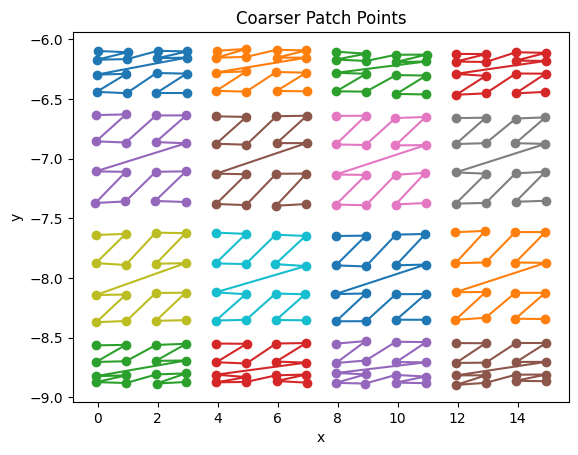

In [607]:
import matplotlib.pyplot as plt

mu = varis_coarser.belief.mu()  # shape (num_patch, 32)
num_patch = mu.shape[0]

for i in range(num_patch):
    patch_points = mu[i].reshape(16, 2)  # 32 -> 16个2D点
    xs, ys = patch_points[:, 0], patch_points[:, 1]
    plt.plot(xs, ys, 'o-', label=f'patch {i}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Coarser Patch Points')

plt.show()




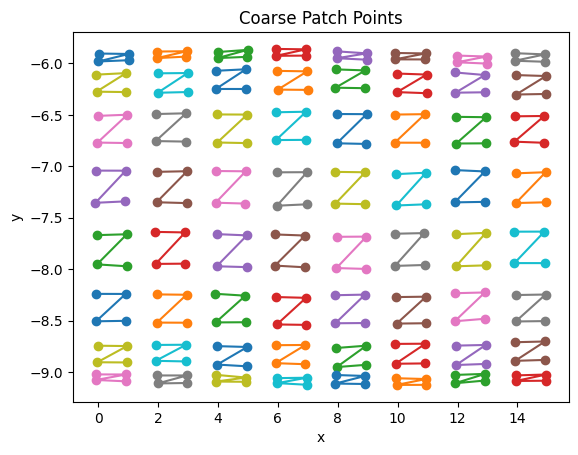

In [608]:
import matplotlib.pyplot as plt

mu = varis_coarse.belief.mu()  # shape (64, 8)
num_patch = mu.shape[0]

for i in range(num_patch):
    patch_points = mu[i].reshape(4, 2)  # 8 -> 4个2D点
    xs, ys = patch_points[:, 0], patch_points[:, 1]
    plt.plot(xs, ys, 'o-')  # 不加label

plt.xlabel('x')
plt.ylabel('y')
plt.title('Coarse Patch Points')
plt.show()



Text(0.5, 1.0, 'Fine Level Points')

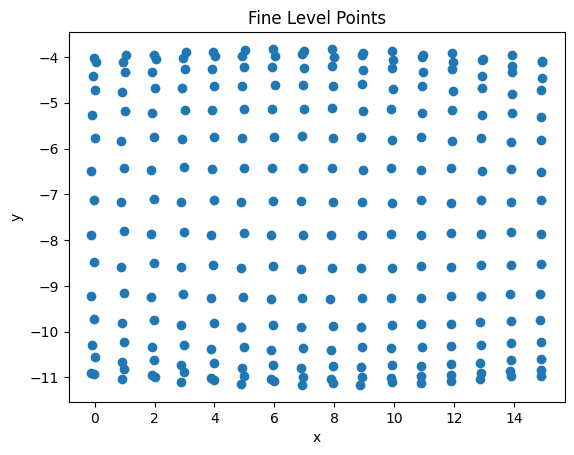

In [548]:
import matplotlib.pyplot as plt

mu = varis.belief.mu()  # shape (256, 2)
xs, ys = mu[:, 0], mu[:, 1]
plt.plot(xs, ys, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fine Level Points')


In [415]:
print("vertical_coarser_facs.z[0]:", vertical_coarser_facs.z[1])
print("h8_fn input shape:", linpoints[vertical_coarser_facs.adj_var_id[1]].shape)
print("h8_fn output:", h8_fn(linpoints[vertical_coarser_facs.adj_var_id[1]]))

vertical_coarser_facs.z[0]: [-0.08031414 -0.04643377 -0.03868708 -0.05102927 -0.16018361 -0.08871809
  0.0812674   0.05872594]
h8_fn input shape: (2, 32)
h8_fn output: [ 0.03712702 -0.80481386 -0.05696821 -0.7988677  -0.1328106  -0.7957225
  0.03902578 -0.7197566 ]


In [416]:
print(varis_coarser.adj_factor_idx)



[[ 0 16 17 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 16 18 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2 18 20 21 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3 20 22 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 4 17 23 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 5 19 23 25 26 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 6 21 25 27 28 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 7 22 27 29 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 8 24 30 31 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9 26 30 32 33 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [10 28 32 34 35 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [11 29 34 36 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [12 31 37 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [13 33 37 38 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [14 35 38 39 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [15 36 39 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [417]:
vertical_coarser_facs.adj_var_id

Array([[ 0,  4],
       [ 1,  5],
       [ 2,  6],
       [ 3,  7],
       [ 4,  8],
       [ 5,  9],
       [ 6, 10],
       [ 7, 11],
       [ 8, 12],
       [ 9, 13],
       [10, 14],
       [11, 15]], dtype=int32)

In [418]:
print(varis_coarse.adj_factor_idx)

[[  0  64  65  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  1  64  66  67  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  2  66  68  69  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  3  68  70  71  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  4  70  72  73  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  5  72  74  75  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  6  74  76  77  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  7  76  78  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  8  65  79  80  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [  9  67  79  81  82  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ 10  69  81  83  84  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ 11  71  83  85  86  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ 12  73  85  87  88  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ 13  75  87  89  90  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ 14  77  89  91  92  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
 [ 15  78  91  93  -1  -1  -1  -1  -1  -1  -1  -1  -1  

In [455]:
#print(energy_log[:50])
print(energy_log_coarse[:50])
print(energy_log_coarser[:50])

[20624.549     785.50134   539.43945   526.0975    525.1677    525.0633
   525.0478    525.04535   525.045     525.04486   525.0448    525.04486
   525.0448    525.04486   525.04486   525.04486   525.0448    525.0449
   525.04486   525.0448    525.04486   525.0448    525.04486   525.0448
   525.0448    525.0448    525.04486   525.04486   525.0448    525.0448
   525.04486   525.0448    525.0448    525.04486   525.04486   525.0448
   525.0448    525.0448    525.04486   525.0448    525.0448    525.0448
   525.04486   525.0448    525.0448    525.04486   525.04486   525.04486
   525.0448    525.0448 ]
[Array(20624.545, dtype=float32), Array(640.5385, dtype=float32), Array(527.1683, dtype=float32), Array(525.16876, dtype=float32), Array(525.05334, dtype=float32), Array(525.0453, dtype=float32), Array(525.0449, dtype=float32), Array(525.04486, dtype=float32), Array(525.0448, dtype=float32), Array(525.0449, dtype=float32), Array(525.0448, dtype=float32), Array(525.04486, dtype=float32), Array(

In [456]:
energy_log

array([20624.55   , 20624.55   ,  1454.8229 ,   601.8854 ,   541.92505,
         529.2502 ,   526.26575,   525.4571 ,   525.199  ,   525.1057 ,
         525.0697 ,   525.05524,   525.0492 ,   525.0467 ,   525.04565,
         525.04517,   525.045  ,   525.0449 ,   525.0449 ,   525.04486,
         525.04486,   525.0448 ,   525.04486,   525.0448 ,   525.04486,
         525.04486,   525.04486,   525.0448 ,   525.04486,   525.04486,
         525.0448 ,   525.04486,   525.0448 ,   525.04486,   525.04486,
         525.04486,   525.04486,   525.04486,   525.0448 ,   525.04486,
         525.04486,   525.0448 ,   525.04486,   525.04486,   525.04486,
         525.0448 ,   525.0448 ,   525.04486,   525.04486,   525.04486,
         525.04486,   525.04486,   525.04486,   525.04486,   525.04486,
         525.04486,   525.04486,   525.04486,   525.04486,   525.04486,
         525.04486,   525.04486,   525.0449 ,   525.04486,   525.04486,
         525.04486,   525.04486,   525.04486,   525.04486,   525

In [457]:
energy_log_coarser[:50]

[Array(20624.545, dtype=float32),
 Array(640.5385, dtype=float32),
 Array(527.1683, dtype=float32),
 Array(525.16876, dtype=float32),
 Array(525.05334, dtype=float32),
 Array(525.0453, dtype=float32),
 Array(525.0449, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.0448, dtype=float32),
 Array(525.0449, dtype=float32),
 Array(525.0448, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dtype=float32),
 Array(525.04486, dty

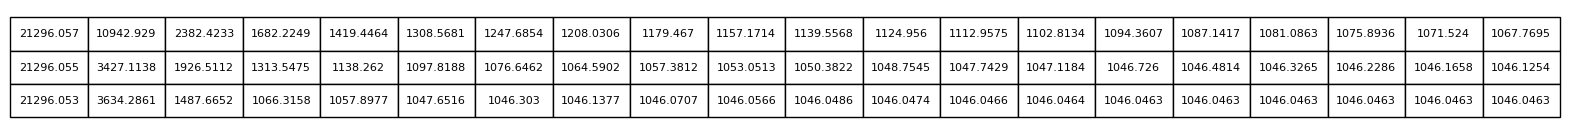

In [430]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 数据准备（前 20 个）
row1 = np.array([21296.057, 10942.929, 2382.4233, 1682.2249, 1419.4464,
                 1308.5681, 1247.6854, 1208.0306, 1179.467, 1157.1714,
                 1139.5568, 1124.956, 1112.9575, 1102.8134, 1094.3607,
                 1087.1417, 1081.0863, 1075.8936, 1071.524, 1067.7695])

row2 = np.array([21296.055, 3427.1138, 1926.5112, 1313.5475, 1138.262,
                 1097.8188, 1076.6462, 1064.5902, 1057.3812, 1053.0513,
                 1050.3822, 1048.7545, 1047.7429, 1047.1184, 1046.726,
                 1046.4814, 1046.3265, 1046.2286, 1046.1658, 1046.1254])

row3 = np.array([21296.053, 3634.2861, 1487.6652, 1066.3158, 1057.8977,
                 1047.6516, 1046.303, 1046.1377, 1046.0707, 1046.0566,
                 1046.0486, 1046.0474, 1046.0466, 1046.0464, 1046.0463,
                 1046.0463, 1046.0463, 1046.0463, 1046.0463, 1046.0463])

# 构建 DataFrame
df = pd.DataFrame([row1, row2, row3])

# 画纯表格（无坐标轴、无标题）
fig, ax = plt.subplots(figsize=(20, 1.5))
ax.axis('off')
table = ax.table(cellText=np.round(df.values, 4), loc='center', cellLoc='center')

# 美化字体大小
table.scale(1, 2)
for key, cell in table.get_celld().items():
    cell.set_fontsize(8)

# 保存为高分辨率图片
plt.savefig("table_sigma1_odom0.1.png", dpi=300, bbox_inches='tight')
plt.show()


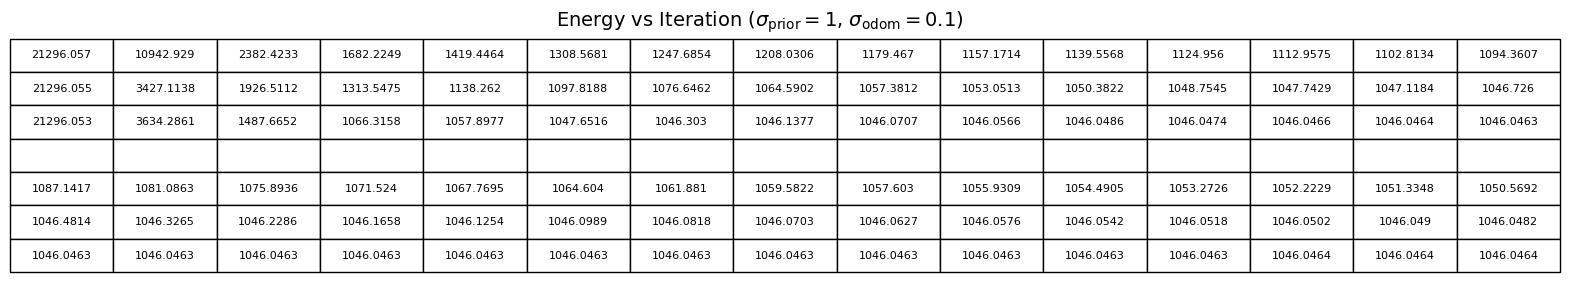

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 拆分每行为两段各 15 个
row1a = np.array([21296.057, 10942.929, 2382.4233, 1682.2249, 1419.4464,
                  1308.5681, 1247.6854, 1208.0306, 1179.467, 1157.1714,
                  1139.5568, 1124.956, 1112.9575, 1102.8134, 1094.3607])
row1b = np.array([1087.1417, 1081.0863, 1075.8936, 1071.524, 1067.7695,
                  1064.604, 1061.881, 1059.5822, 1057.603, 1055.9309,
                  1054.4905, 1053.2726, 1052.2229, 1051.3348, 1050.5692])

row2a = np.array([21296.055, 3427.1138, 1926.5112, 1313.5475, 1138.262,
                  1097.8188, 1076.6462, 1064.5902, 1057.3812, 1053.0513,
                  1050.3822, 1048.7545, 1047.7429, 1047.1184, 1046.726])
row2b = np.array([1046.4814, 1046.3265, 1046.2286, 1046.1658, 1046.1254,
                  1046.0989, 1046.0818, 1046.0703, 1046.0627, 1046.0576,
                  1046.0542, 1046.0518, 1046.0502, 1046.049, 1046.0482])

row3a = np.array([21296.053, 3634.2861, 1487.6652, 1066.3158, 1057.8977,
                  1047.6516, 1046.303, 1046.1377, 1046.0707, 1046.0566,
                  1046.0486, 1046.0474, 1046.0466, 1046.0464, 1046.0463])
row3b = np.array([1046.0463, 1046.0463, 1046.0463, 1046.0463, 1046.0463,
                  1046.0463, 1046.0463, 1046.0463, 1046.0463, 1046.0463,
                  1046.0463, 1046.0463, 1046.0464, 1046.0464, 1046.0464])

# 空行
empty = np.array([""] * 15)

# 构造 DataFrame
df = pd.DataFrame([
    np.round(row1a, 4),
    np.round(row2a, 4),
    np.round(row3a, 4),
    empty,
    np.round(row1b, 4),
    np.round(row2b, 4),
    np.round(row3b, 4),
])

# 绘图
fig, ax = plt.subplots(figsize=(20, 3))
ax.axis('off')

table = ax.table(cellText=df.values.tolist(), loc='center', cellLoc='center')

# 设置字体
table.scale(1, 2)
for key, cell in table.get_celld().items():
    cell.set_fontsize(8)

# 标题
fig.suptitle(r'Energy vs Iteration ($\sigma_{\mathrm{prior}} = 1$, $\sigma_{\mathrm{odom}} = 0.1$)', fontsize=14)

# 保存
plt.savefig("table_sigma1_odom0.1_split_top30.png", dpi=500, bbox_inches='tight')
plt.show()


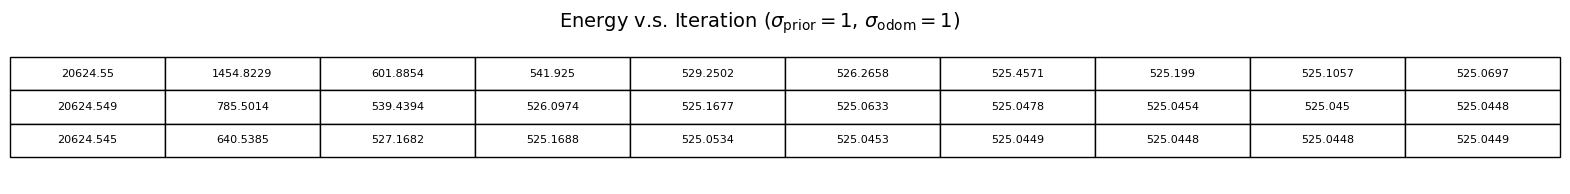

In [459]:
# 取前10个数据
row1_10 = np.array(energy_log[1:11])

row2_10 = np.array(energy_log_coarse[0:10])

row3_10 = np.array(energy_log_coarser[0:10])

df_10 = pd.DataFrame([row1_10, row2_10, row3_10])

# 绘图
fig, ax = plt.subplots(figsize=(20, 2))
ax.axis('off')
table = ax.table(cellText=np.round(df_10.values, 4), loc='center', cellLoc='center')

# 设置字体大小
table.scale(1, 2)
for key, cell in table.get_celld().items():
    cell.set_fontsize(8)

# 添加标题（含 σ 符号）
fig.suptitle(r'Energy v.s. Iteration ($\sigma_{\mathrm{prior}} = 1$, $\sigma_{\mathrm{odom}} = 1$)', fontsize=14)

# 保存图像
plt.savefig("table_sigma1_odom1_top10.png", dpi=500, bbox_inches='tight')
plt.show()


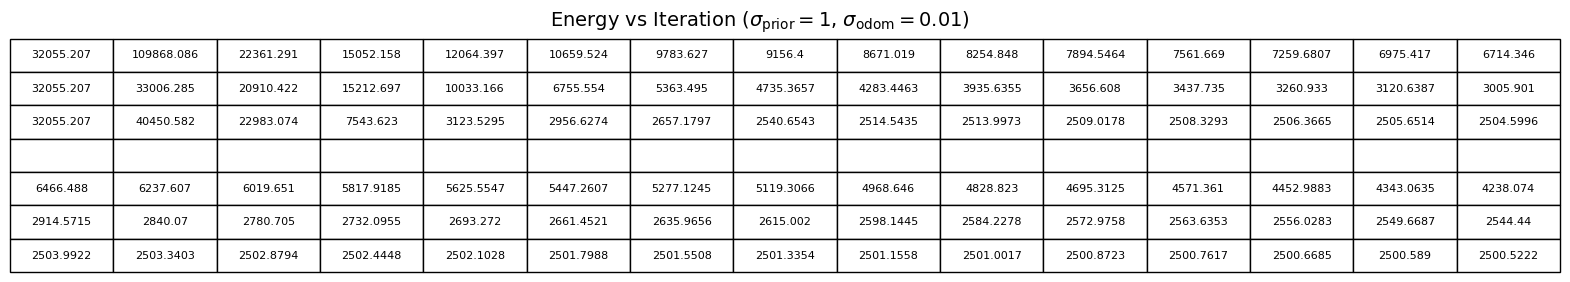

In [529]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 数据准备
row1 = np.array(energy_log[1:16])
row2 = np.array(energy_log_coarse[0:15])
row3 = np.array(energy_log_coarser[0:15])
empty = np.array([""] * 15)  # 空白行
row4 = np.array(energy_log[16:31])
row5 = np.array(energy_log_coarse[15:30])
row6 = np.array(energy_log_coarser[15:30])

# 构造 DataFrame（注意转成 string 或 float 都可以）
df = pd.DataFrame([
    np.round(row1, 4),
    np.round(row2, 4),
    np.round(row3, 4),
    empty,
    np.round(row4, 4),
    np.round(row5, 4),
    np.round(row6, 4)
])

# 绘图
fig, ax = plt.subplots(figsize=(20, 3))
ax.axis('off')
table = ax.table(cellText=df.values.tolist(), loc='center', cellLoc='center')

# 设置字体
table.scale(1, 2)
for key, cell in table.get_celld().items():
    cell.set_fontsize(8)

# 添加标题
fig.suptitle(r'Energy vs Iteration ($\sigma_{\mathrm{prior}} = 1$, $\sigma_{\mathrm{odom}} = 0.01$)', fontsize=14)

# 保存
plt.savefig("table_sigma1_odom0.01_split_blankrow.png", dpi=500, bbox_inches='tight')
plt.show()
